In [ ]:
!pip install transformers
!pip install torch
!pip install nltk
!pip install spacy

     |████████████████████████████████| 2.8 MB 4.1 MB/s 
     |████████████████████████████████| 52 kB 1.7 MB/s 
     |████████████████████████████████| 636 kB 62.9 MB/s 
     |████████████████████████████████| 895 kB 50.0 MB/s 
     |████████████████████████████████| 3.3 MB 28.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install Datasets

     |████████████████████████████████| 270 kB 4.0 MB/s 
     |████████████████████████████████| 1.3 MB 50.8 MB/s 
     |████████████████████████████████| 243 kB 69.1 MB/s 
     |████████████████████████████████| 119 kB 72.6 MB/s 
     |████████████████████████████████| 142 kB 68.1 MB/s 
     |████████████████████████████████| 294 kB 72.0 MB/s 


In [ ]:
!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm
!python -m spacy download fr_core_news_sm

     |████████████████████████████████| 12.0 MB 4.1 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
     |████████████████████████████████| 16.2 MB 4.2 MB/s 
  Created wheel for es-core-news-sm: filename=es_core_news_sm-2.2.5-py3-none-any.whl size=16172933 sha256=c51085248b2fe3e3e843979af95464f39cc75eb5bb48a1cd7b15278f1a39bc04
  Stored in directory: /tmp/pip-ephem-wheel-cache-j_m49qx5/wheels/21/8d/a9/6c1a2809c55dd22cd9644ae503a52ba6206b04aa57ba83a3d8
Successfully built es-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('es_core_news_sm')
     |████████████████████████████████| 14.7 MB 4.3 MB/s 
  Created wheel for fr-core-news-sm: filename=fr_core_news_sm-2.2.5-py3-none-any.whl size=14727026 sha256=b929c97d4c821e6463b5fbc5d9fba1a142583609b11cb41c8fd13a2fdbb9abac
  Stored in directory: /tmp/pip-ephem-wheel-cache-pydnbs2u/wheels/c9/a6/ea/0778337c34660027ee67ef3a91fb9d3600b76777a912ea1c2

Esta es la asignación de recuperación, aca realizaremos el entrenamiento de un modelo de Text Classification en un Dataset de Amazon, el objectivo es clasificar criticas de distintos usuarios.

Para entrenar un modelo utilizaremos Pytoch y HuggingFace, tambien se utilizaran otras librerias de manipulacion de texto (nltk,spacy),manipulacion de datos (pandas), funciones matematicas y visualizacion.



Este dataset puede ser obtenido de distintas formas, por razones de comodida utilizaremos la libreria Datasets de HuggingFace para descargarlo

In [ ]:
import pandas as pd
import spacy
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import os
from pprint import pprint
from sklearn.preprocessing import LabelEncoder

from torch.utils.data import DataLoader,Dataset
from transformers import AutoTokenizer,AutoModelForSequenceClassification,BertModel,BertForSequenceClassification,BertConfig,AutoConfig
import torch
from torch import cuda
import numpy as np
from sklearn import metrics
from tqdm import tqdm 
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,recall_score,precision_score
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


Generamos un dataset con el nombre de los modelos pre-entrenados y el nombre de los modulos de spacy para tratar cada casa (Ingles,Español y Frances).

In [ ]:
lang = 'en'

In [ ]:
dict_lang = {'en':['bert-base-uncased','en_core_web_sm','english'],
             'es':['dccuchile/bert-base-spanish-wwm-uncased','es_core_news_sm','spanish'],
             'fr':['flaubert/flaubert_base_cased', 'fr_core_news_sm','french']}

In [ ]:
model_name,spacy_lang,lang_stem = dict_lang[lang]

In [ ]:
def load_amzn_dataset(lang,pct_rows):

  """Esta funcion carga un dataset de la libreria Dataset,
     se transforman a un Pandas DataFrame para una mejor visuzalización y manipulación de datos,
     la funcion retorna tres datasets (train,validation y test)  """

  if lang not in dict_lang.keys():
            
    raise ValueError('Esta función solo maneja 3 lenguajes es,en y fr, por favor elija una de estos tres')

  else:
    
    dataset = load_dataset("amazon_reviews_multi", lang)


  pd_data_tr = pd.DataFrame(dataset['train'])
  pd_data_val = pd.DataFrame(dataset['validation'])
  pd_data_ts = pd.DataFrame(dataset['test'])

  pd_data_tr = pd_data_tr.sample(frac = pct_rows,random_state = 42)
  pd_data_val = pd_data_val.sample(frac = pct_rows,random_state = 42)
  pd_data_ts = pd_data_ts.sample(frac = pct_rows,random_state = 42)

  pd_data_tr['stars'],pd_data_val['stars'],pd_data_ts['stars'] = pd_data_tr['stars'].apply(lambda x : str(x)),pd_data_val['stars'].apply(lambda x : str(x)),pd_data_ts['stars'].apply(lambda x : str(x))
  

  return pd_data_tr,pd_data_val,pd_data_ts

  

In [ ]:
data_tr, data_val, data_ts = load_amzn_dataset(lang,0.05)


Downloading:   0%|          | 0.00/2.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.62k [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/82.0M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/2.06M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/2.05M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset amazon_reviews_multi downloaded and prepared to /root/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
data_tr.shape

(10000, 8)

In [ ]:
data_tr.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
119737,en_0522546,product_en_0681589,reviewer_en_0687817,3,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,en,lawn_and_garden
72272,en_0612910,product_en_0295449,reviewer_en_0312138,2,"The leg openings are a little small, but other...",Crap,en,apparel
158154,en_0983065,product_en_0295095,reviewer_en_0927618,4,Really cute mug. I would have given 5 stars if...,Four Stars,en,kitchen
65426,en_0206761,product_en_0563487,reviewer_en_0936741,2,Well it’s looks and feels okay but it most cer...,Lies!!,en,industrial_supplies
30074,en_0510474,product_en_0704805,reviewer_en_0417600,1,"Very, very thin, you can bend them with you fi...",Thin and bendable :(,en,pet_products


Realizamos un breve analizis exploratorio de datos.Primero descartamos las columnas que no seran utilizadas. Para este analisis nos el tokenizer seria de gran utilidad por lo que importaremos AutoToeknizer de la libreria transformers.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
data_tr = data_tr[['review_body','stars','product_category']]
data_val = data_val[['review_body','stars','product_category']]

le = LabelEncoder()

data_tr['label'] = le.fit_transform(data_tr['stars'])
data_val['label'] = le.fit_transform(data_val['stars'])
#data_tr = data_tr.loc[:,['title','label']]
#data_tr['label'] = data_tr['label'].apply(lambda x: str(x))
classes = dict(zip(le.classes_,le.transform(le.classes_)))

In [ ]:
classes

{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4}

In [ ]:

data_tr['n_tokens'] = data_tr['review_body'].apply(lambda x : len(tokenizer.tokenize(x)))

Token indices sequence length is longer than the specified maximum sequence length for this model (754 > 512). Running this sequence through the model will result in indexing errors


(array([8.841e+03, 9.560e+02, 1.430e+02, 3.800e+01, 1.100e+01, 6.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 2.000e+00]),
 array([  3. ,  81.3, 159.6, 237.9, 316.2, 394.5, 472.8, 551.1, 629.4,
        707.7, 786. ]),
 <a list of 10 Patch objects>)

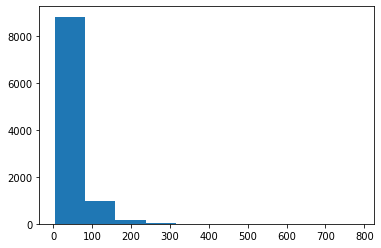

In [ ]:
plt.hist(data_tr['n_tokens'])

In [ ]:
data_tr.groupby('product_category')['n_tokens'].apply(lambda x : np.int(np.mean(x)))

product_category
apparel                     33
automotive                  37
baby_product                50
beauty                      41
book                        37
camera                      44
digital_ebook_purchase      49
digital_video_download      37
drugstore                   38
electronics                 44
furniture                   47
grocery                     35
home                        40
home_improvement            42
industrial_supplies         37
jewelry                     28
kitchen                     46
lawn_and_garden             42
luggage                     38
musical_instruments         44
office_product              38
other                       39
pc                          47
personal_care_appliances    53
pet_products                50
shoes                       34
sports                      42
toy                         38
video_games                 42
watch                       35
wireless                    45
Name: n_tokens, dtype:

In [ ]:
data_tr['n_tokens'].describe()

count    10000.000000
mean        41.297500
std         42.666263
min          3.000000
25%         15.000000
50%         29.000000
75%         53.000000
max        786.000000
Name: n_tokens, dtype: float64

In [ ]:
data_tr = data_tr[data_tr['n_tokens'] < 512]
data_tr.shape

(9996, 5)

Con este histograma podemos observar que la gran mayoria de textos constan de 34 tokens, esto es importante debido a que mas adelante definiremos que tiene gran influencia en el comportamiento del modelo, afecta directamente la cantidad de tiempo que el modelo entrena y la capacidad de generalizar distintos ejemplos. 

In [ ]:
data_tr['n_tokens'].describe()

count    9996.000000
mean       41.025210
std        40.431994
min         3.000000
25%        15.000000
50%        29.000000
75%        53.000000
max       474.000000
Name: n_tokens, dtype: float64

Realizaremos algunas tecnicas de NLP, removeremos las 'stopwords,lemmatizacion y steaming, compararemos el comportaminedo del modelo de clasificación utilizando cada uno de estos inputs. 

Lo que haremos es comparar como se comporta el modelo utilizando el texto original, sin palabras stop, lemmatizado y con el porcesos de steam.

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.stem.snowball import SnowballStemmer

In [ ]:
nlp = spacy.load(spacy_lang)

def nlp_functions(text,lang_stem,task = 'stopwords',nlp_ = nlp):

  stp_list = stopwords.words(lang_stem)

  for w in stp_list:
    
    nlp.vocab[w].is_stop = True


  if task == 'stopwords':
  
    return  " ".join(token.text for token in nlp(text) if not token.is_stop)


  elif task == 'lemma':


    return  " ".join(str(token.lemma_) for token in nlp(text) if not token.is_stop)


  elif task == 'stem':

    stemmer = SnowballStemmer(language=lang_stem)

    return  " ".join(stemmer.stem(token.text) for token in nlp(text) if stemmer.stem(token.text) not in stp_list )

  else:

    raise ValueError('Esta función solo maneja 3 tareas limpieza de palabras,lemmatizacion y stemming, por favor elija una de estas tres opciones')





  




In [ ]:
data_tr['product_category'].nunique()

31

In [ ]:
data_tr.groupby('stars').size()

stars
1    1968
2    1980
3    1980
4    1998
5    2070
dtype: int64

In [ ]:
data_tr.groupby('product_category').size()

product_category
apparel                     761
automotive                  390
baby_product                155
beauty                      579
book                        175
camera                      105
digital_ebook_purchase      353
digital_video_download       67
drugstore                   592
electronics                 310
furniture                   156
grocery                     226
home                        873
home_improvement            363
industrial_supplies          98
jewelry                     140
kitchen                     520
lawn_and_garden             326
luggage                      74
musical_instruments          60
office_product              313
other                       718
pc                          320
personal_care_appliances      3
pet_products                368
shoes                       279
sports                      396
toy                         430
video_games                  45
watch                        44
wireless               

In [ ]:
data_tr.groupby(['product_category','stars']).size()

product_category  stars
apparel           1        136
                  2        153
                  3        176
                  4        183
                  5        113
                          ... 
wireless          1        183
                  2        183
                  3        132
                  4        132
                  5        127
Length: 153, dtype: int64

In [ ]:
data_tr['stp_wrd'] = data_tr['review_body'].apply(lambda x : nlp_functions(x,lang_stem,task = 'stopwords'))
data_val['stp_wrd'] = data_val['review_body'].apply(lambda x : nlp_functions(x,lang_stem,task = 'stopwords'))


In [ ]:
data_tr['lemma'] = data_tr['review_body'].apply(lambda x : nlp_functions(x,lang_stem,task = 'lemma'))
data_val['lemma'] = data_val['review_body'].apply(lambda x : nlp_functions(x,lang_stem,task = 'lemma'))


In [ ]:
data_tr['stem'] = data_tr['review_body'].apply(lambda x : nlp_functions(x,lang_stem,task = 'stem'))
data_val['stem'] = data_val['review_body'].apply(lambda x : nlp_functions(x,lang_stem,task = 'stem'))

In [ ]:
classes

{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4}

In [ ]:
for key in classes.keys():

    classes[key] = int(classes[key])

In [ ]:

config = BertConfig.from_pretrained(
    pretrained_model_name_or_path = model_name,
    num_labels = len(classes),
    label2id = classes,
    id2label = dict(zip(classes.values(),classes.keys()))
    )

In [ ]:
data_tr.to_csv('data_complete.csv')

In [ ]:
class DatasetMCLass(Dataset):

    def __init__(self, text, targets, tokenizer, max_len):

      self.text = text
      self.targets = targets
      self.tokenizer = tokenizer
      self.max_len = max_len

    def __len__(self):

      return len(self.text)

    def __getitem__(self, index):

      text = str(self.text[index])
      
      targets = int(self.targets[index])
      
      encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=True,
        pad_to_max_length=True,
        return_attention_mask=True)
      
      input_ids = encoding['input_ids']

      attention_mask = encoding['attention_mask']

      token_type_ids = encoding['token_type_ids']

      return {
        #'review_text': text,
        'input_ids': torch.tensor(input_ids, dtype = torch.long),
        'attention_mask': torch.tensor(attention_mask, dtype = torch.long),
        'targets': torch.tensor(targets, dtype=torch.long)
        #'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
    }

In [ ]:
data_tr.reset_index(inplace=True,drop=True)
data_val.reset_index(inplace=True,drop=True)
data_tr.head()

,review_body,stars,product_category,label,n_tokens,stp_wrd,lemma,stem
0,Not strong enough to run a small 120v vacuum c...,3,lawn_and_garden,2,16,"strong run small 120v vacuum cleaner , clean c...","strong run small 120v vacuum cleaner , clean c...","strong enough run small 120v vacuum cleaner , ..."
1,"The leg openings are a little small, but other...",2,apparel,1,74,"leg openings little small , suit fits nicely ,...","leg opening little small , suit fit nicely , h...","leg open littl small , suit fit nice , high qu..."
2,Really cute mug. I would have given 5 stars if...,4,kitchen,3,17,cute mug . given 5 stars bit bigger .,cute mug . give 5 star bit big .,realli cute mug . would given 5 star bit bigger .
3,Well it’s looks and feels okay but it most cer...,2,industrial_supplies,1,55,looks feels okay certainly 4 pockets lie 3 pre...,look feel okay certainly 4 pocket lie 3 pretty...,well ’s look feel okay certain doe 4 pocket ’s...
4,"Very, very thin, you can bend them with you fi...",1,pet_products,0,33,", thin , bend fingers problem ! Print small .....",", thin , bend finger problem ! Print small .. ...","veri , veri thin , bend finger problem ! print..."


In [ ]:
data_val.head()

,review_body,stars,product_category,label,stp_wrd,lemma,stem
0,I bought these for driving; they are ok for th...,2,shoes,1,bought driving ; ok . change dark sun stay gra...,buy drive ; ok . change dark sun stay gray ins...,bought drive ; ok . n't chang veri dark sun st...
1,Good for cool days on the beach but not good f...,3,apparel,2,Good cool days beach good warmer days .,good cool day beach good warm day .,good cool day beach good warmer day .
2,I like it but it’s not my favorite bc even whe...,3,office_product,2,like favorite bc u press firmly ink bright get...,like favorite bc u press firmly ink bright get...,like ’s favorit bc even u press firm ink n't b...
3,Product was great but the box was smooshed and...,2,other,1,Product great box smooshed bandaids . like car...,product great box smooshe bandaid . like care ...,product great box smoosh bandaid . ’s like n't...
4,I have chronic knee pains due to arthritis. I ...,1,drugstore,0,chronic knee pains arthritis . gave product tr...,chronic knee pain arthritis . give product try...,chronic knee pain due arthriti . gave product ...


In [ ]:
ml_columns = ['review_body', 'stp_wrd',
       'lemma', 'steam']

In [ ]:
def calcuate_accu_label(big_idx, targets):

    n_correct = (big_idx==np.argmax(targets)).sum().item()
    
    return n_correct

def calcuate_accu_class(big_idx, targets):

    n_correct = (big_idx==targets).sum().item()
    
    return n_correct


        
def train(epoch,model,training_loader,device,optimizer,loss_fn):
    
    model.train()
    
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    loss_function = loss_fn

    for _,batch in enumerate(training_loader, 0):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        #token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)['logits']#.squeeze()

        preds = torch.tensor(torch.argmax(outputs, axis=-1))

        loss = loss_function(outputs, targets)

        tr_loss += loss.item()

        #big_val, big_idx = torch.max(outputs.data, dim=1)

        n_correct += calcuate_accu_class(preds, targets)

        nb_tr_steps += 1

        nb_tr_examples+=targets.size(0)

        if _% 10 ==0:

            tg_np = targets.cpu().detach().numpy()

            pd_np = preds.cpu().detach().numpy()


            precision = precision_score(tg_np,pd_np,average='macro')
            
            recall = recall_score(tg_np,pd_np,average='macro')

            loss_step = tr_loss/nb_tr_steps

            accu_step = (n_correct*100)/nb_tr_examples 

            print(f'Epoch_tr: {epoch}, Step_tr: {_} ,Loss_tr:  {loss.item()},Acc_tr: {accu_step},recall_tr: {recall},precision_tr: {precision}')

            print(5*'\t')
            
            

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples

    return epoch_accu,epoch_loss,recall,precision


def validation(epoch,model,testing_loader,device,optimizer,loss_fn):

    model.eval()

    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    
    fin_targets=[]
    
    fin_outputs=[]
    
    with torch.no_grad():
    
        for _, batch in enumerate(testing_loader, 0):
    
            ids = batch['input_ids'].to(device, dtype = torch.long)
    
            mask = batch['attention_mask'].to(device, dtype = torch.long)
    
            #token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
    
            targets = batch['targets'].to(device, dtype = torch.long)
    
            outputs = model(ids, mask)['logits']#.squeeze()
    
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
    
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

            preds = torch.tensor(torch.argmax(outputs, axis=-1))

            loss = loss_fn(outputs, targets)

            tr_loss += loss.item()

            #big_val, big_idx = torch.max(outputs.data, dim=1)

            n_correct += calcuate_accu_class(preds, targets)

            nb_tr_steps += 1

            nb_tr_examples+=targets.size(0)

            if _% 10 ==0:

                tg_np = targets.cpu().detach().numpy()

                pd_np = preds.cpu().detach().numpy()

                precision = precision_score(tg_np,pd_np,average='macro')
            
                recall = recall_score(tg_np,pd_np,average='macro')

                loss_step = tr_loss/nb_tr_steps

                accu_step = (n_correct*100)/nb_tr_examples 


            #print(f'Epoch_vsl: {epoch}, Step_val: {_} ,Loss_val:  {loss_step},Acc_val: {accu_step},recall_val : {recall},precision_val : {precision}')

            #print(5*'\t')

            epoch_loss = tr_loss/nb_tr_steps

            epoch_accu = (n_correct*100)/nb_tr_examples
    
        return epoch_accu,epoch_loss,recall,precision

In [ ]:
n_classes = len(classes)

MAX_LEN = 64

TRAIN_BATCH_SIZE = 128

VALID_BATCH_SIZE = 32

EPOCHS = 5

LEARNING_RATE = 1e-05


In [ ]:
#train,validation  = train,validation
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:

dict_tr_results = {}
dict_val_results = {}

columns_df = ['epoch','accuracy','loss','recall','precision']

for col in ml_columns:

    model = BertForSequenceClassification.from_pretrained(pretrained_model_name_or_path= model_name,config = config)

    optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)


    device = 'cuda' if cuda.is_available() else 'cpu'

    model.to(device)

    loss_fcn = torch.nn.CrossEntropyLoss()

    train_acc_list = []
    train_loss_list = []
    recall_list = []
    precision_list = []
    epoch_list = []

    training_set = DatasetMCLass(data_tr[col],data_tr['label'], tokenizer, MAX_LEN)

    validation_set = DatasetMCLass(data_val[col],data_val['label'], tokenizer, MAX_LEN)

    train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

    val_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

    training_loader = DataLoader(training_set, **train_params)

    validation_loader = DataLoader(validation_set, **val_params)

    
    for epoch in range(EPOCHS):

        acc,loss,recall,precision = train(epoch = epoch, model = model,training_loader = training_loader, device = device,optimizer = optimizer,loss_fn = loss_fn)

        train_acc_list.append(acc)
        train_loss_list.append(loss)
        recall_list.append(recall)
        precision_list.append(precision)
        epoch_list.append(epoch)

    dict_tr_results[col] = pd.DataFrame(zip(epoch_list,train_acc_list,train_loss_list,recall_list,precision_list),columns = columns_df)

    model.eval()

    acc_val,loss_val,recall_val,precision_val = validation(epoch = epoch,model = model,testing_loader = validation_loader,device = device,optimizer = optimizer,loss_fn = loss_fn )

 

    dict_val_results[col] = pd.DataFrame([accuracy_val,loss_val,recall_val,precision_val],columns = ['accuracy','recall','precision'])


    print(f'Finalizo el entrenamiento y validacion del modelo utilizando la columna {col}')

    break

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch_tr: 0, Step_tr: 0 ,Loss_tr:  1.7084896564483643,Acc_tr: 12.5,recall_tr: 0.21428571428571427,precision_tr: 0.22222222222222224
					
Epoch_tr: 0, Step_tr: 10 ,Loss_tr:  1.5905579328536987,Acc_tr: 22.301136363636363,recall_tr: 0.3355555555555555,precision_tr: 0.2711764705882353
					
Epoch_tr: 0, Step_tr: 20 ,Loss_tr:  1.567221760749817,Acc_tr: 24.330357142857142,recall_tr: 0.2946428571428571,precision_tr: 0.26425396825396824
					
Epoch_tr: 0, Step_tr: 30 ,Loss_tr:  1.4881771802902222,Acc_tr: 26.864919354838708,recall_tr: 0.37307359307359306,precision_tr: 0.28786764705882356
					
Epoch_tr: 0, Step_tr: 40 ,Loss_tr:  1.4777462482452393,Acc_tr: 29.26829268292683,recall_tr: 0.3396825396825397,precision_tr: 0.3527272727272727
					
Epoch_tr: 0, Step_tr: 50 ,Loss_tr:  1.2980616092681885,Acc_tr: 30.85171568627451,recall_tr: 0.41680789798436857,precision_tr: 0.5113636363636364
					
Epoch_tr: 0, Step_tr: 60 ,Loss_tr:  1.305881142616272,Acc_tr: 32.24897540983606,recall_tr: 0.3437354312354

KeyboardInterrupt: ignored

In [ ]:
for col in ml_columns:

  print(dict_val_results['col'])